Saint Lucia is a independent country in the Caribbean Sea and has a population of 174,000 (2010). Its capital is Castries. Saint Lucia may face the following natural hazards:
* 

In [11]:
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [12]:
import pandas as pd
import os
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np
from tqdm import tqdm
from matplotlib.ticker import MaxNLocator
import json
import ptitprince as pt
# import contextily as ctx
from analysis import *

## Specify parameters

First we need to specify the paths to the experiment results. The structure of `experiments` folder is as folows. First goes the `country` name, then `state` or `district` name, then the name of the `policy` and finally `scenario`.

In [19]:
districts

['AnseLaRayeCanaries',
 'Castries',
 'Choiseul',
 'Dennery',
 'Gros Islet',
 'Laborie',
 'Micoud',
 'Soufriere',
 'Vieuxfort']

In [13]:
country = 'Saint Lucia'
districts = next(os.walk(f'../experiments/{country}'))[1]
policies = next(os.walk(f'../experiments/{country}/{districts[0]}'))[1]
scenarios = next(os.walk(f'../experiments/{country}/{districts[0]}/{policies[0]}'))[1]
with open(f'../experiments/{country}/{districts[0]}/{policies[0]}/{scenarios[0]}/parameters.json') as f:
    parameters = json.load(f)
n_replications = parameters['n_replications']

print(f'Country: {country}')
print(f'Districts: {districts}')
print(f'Policies: {policies}')
print(f'Scenarios: {scenarios}')
print(f'Replications: {n_replications}')

Country: Saint Lucia
Districts: ['AnseLaRayeCanaries', 'Castries', 'Choiseul', 'Dennery', 'Gros Islet', 'Laborie', 'Micoud', 'Soufriere', 'Vieuxfort']
Policies: ['None']
Scenarios: ['100']
Replications: 200


## Load data

Now we can load the files of interest.

In [14]:
experiments = load_experiments(districts, policies, scenarios, country, n_replications)

AnseLaRayeCanaries's PML: 1,282,936
Castries's PML: 31,062,668
Choiseul's PML: 1,111,848
Dennery's PML: 2,667,414
Gros Islet's PML: 10,932,608
Laborie's PML: 2,035,118
Micoud's PML: 4,766,542
Soufriere's PML: 1,679,254
Vieuxfort's PML: 4,264,030


In [15]:
def prepare_outcomes(outcomes_of_interest:list, print_statistics:bool=True, tests:bool=True) -> dict:
    pass

## Multiple replications

In [16]:
# Structure of the outcomes dataframe:
# scenario -> policy -> district -> replication -> outcome

In [17]:
n_years = 10

columns = ['scenario', 'policy', 'district', 'replication', 
           'total_population', 
           'n_affected', 
           'average_aeexp_affected_person', 
           'annual_average_consumption_loss', 
           'annual_average_consumption_loss_pct', 
           'poor_initial',
           'new_poor', 
           'total_consumption_loss',
           'pml',
           'r']

l = []

stats = {}

for scenario in scenarios:
    for policy in policies:
        for district in districts:
            stats[district] = {}
            no_affected_households = 0
            n_resilience_more_than_1 = 0
            for replication in range(n_replications):

                # Get the households
                households = experiments[district][policy][scenario][replication]
                total_population = round(households['popwgt'].sum())
                affected_households = households[households['is_affected'] == True]
                n_affected = round(affected_households['popwgt'].sum())

                # * Some runs give no affected households
                # We will skip these
                if len(affected_households) == 0:
                    no_affected_households += 1
                    continue

                # * Poverty line can be different across replications
                poverty_line = households['poverty_line_adjusted'].values[0]

                # Get these only for stats
                district_total_households = round(households['popwgt'].sum())
                district_total_affected_households = round(households[households['is_affected'] == True]['popwgt'].sum())
                poor = households[households['is_poor'] == True]
                poor_initial = round(poor['popwgt'].sum())
                total_affected_poor = round(poor[poor['is_affected'] == True]['popwgt'].sum())

                # Find new poor AT THE END of the simulation (n_years)
                not_poor = households[households['is_poor'] == False]
                not_poor_affected = not_poor[not_poor['is_affected'] == True]
                x = not_poor_affected['aeexp'] - not_poor_affected['consumption_loss_NPV'] / n_years
                new_poor = not_poor_affected.loc[x < poverty_line,:]
                n_new_poor = round(new_poor['popwgt'].sum())
                
                # Calculate ANNUAL average consumption loss per affected person
                annual_consumption_loss = (affected_households['consumption_loss_NPV'] / n_years * affected_households['popwgt']).sum()
                # PER AFFECTED PERSON
                annual_average_consumption_loss = annual_consumption_loss / affected_households['popwgt'].sum()
                
                # ANNUAL average consumption
                annual_average_consumption = (affected_households['aeexp'] * affected_households['popwgt']).sum() / affected_households['popwgt'].sum()
                
                # Calculate ANNUAL average consumption loss per affected person as a percentage of ANNUAL average consumption
                annual_average_consumption_loss_pct = annual_average_consumption_loss / annual_average_consumption

                if annual_average_consumption_loss_pct > 1:
                    raise Exception('Annual average consumption loss is greater than 1')

                # Calculate TOTAL consumption loss for all affected households
                total_consumption_loss = (affected_households['consumption_loss_NPV'] * affected_households['popwgt']).sum()
        
                # Calculate resilience
                pml = households['pml'].iloc[0]
                r = pml / total_consumption_loss

                # # * Sometimes resilience is greater than 1
                # We will set it to 1 then
                if r > 5:
                    r = 1
                    # raise Exception('Resilience is greater than 1')
                    n_resilience_more_than_1 += 1
                    # continue

                average_aeexp_affected_person = (affected_households['aeexp'] * affected_households['popwgt']).sum() / affected_households['popwgt'].sum()

                s = pd.Series([scenario, policy, district, replication, 
                               total_population, 
                               n_affected, 
                               average_aeexp_affected_person, 
                               annual_average_consumption_loss,
                               annual_average_consumption_loss_pct, 
                               poor_initial,
                               n_new_poor, 
                               total_consumption_loss,
                               pml, 
                               r
                               ], index=columns)
                l.append(s)
                
            stats[district]['no_affected_households'] = no_affected_households
            stats[district]['n_resilience_more_than_1'] = n_resilience_more_than_1
            stats[district]['n_resilience_more_than_1_pct'] = n_resilience_more_than_1 / n_replications

stats = pd.DataFrame(stats).T
outcomes = pd.DataFrame(l)

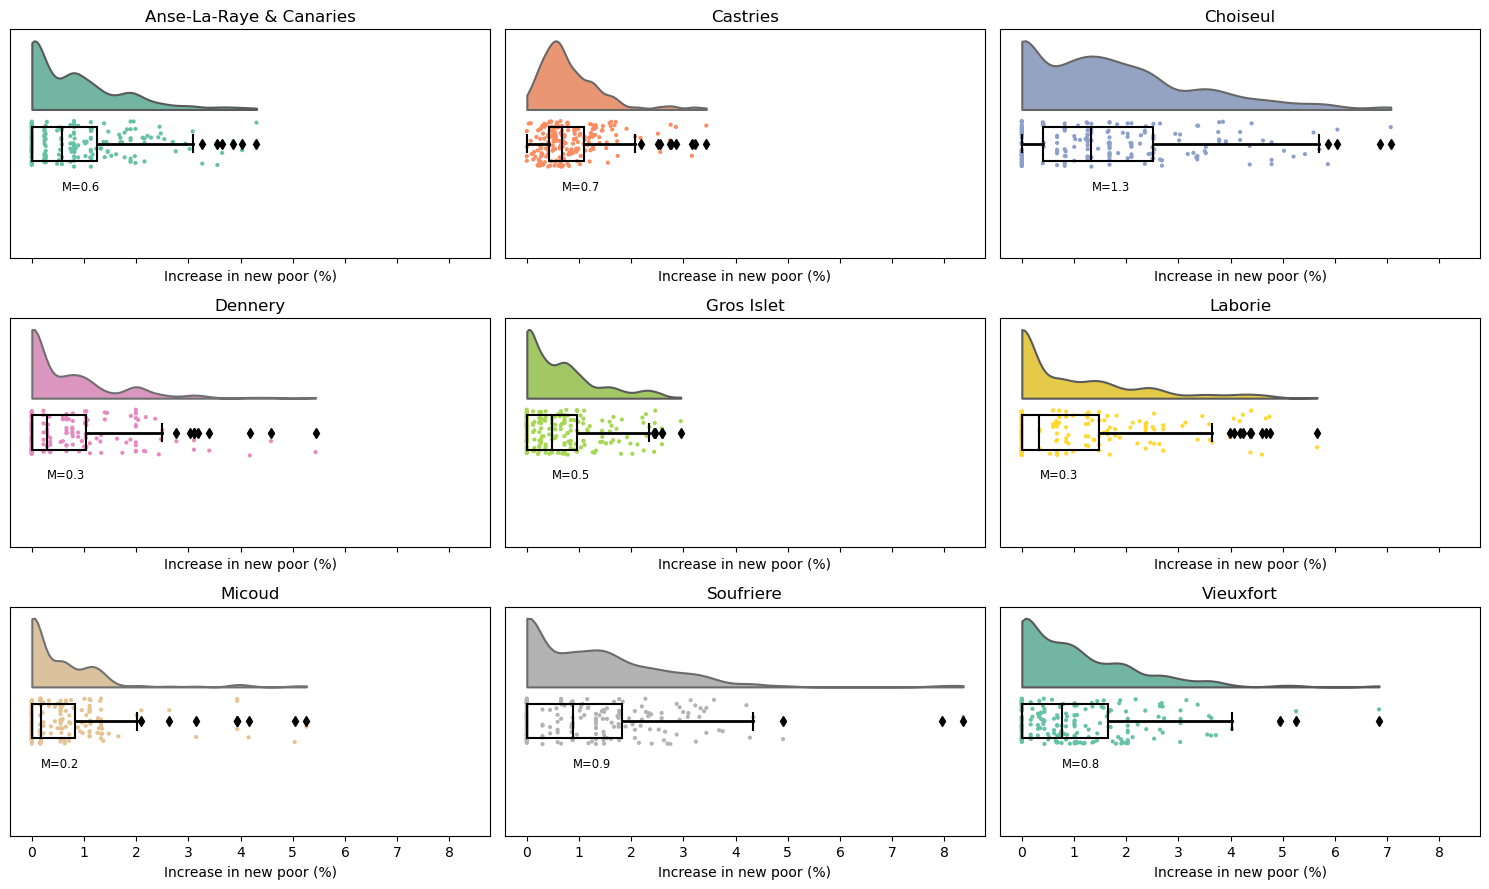

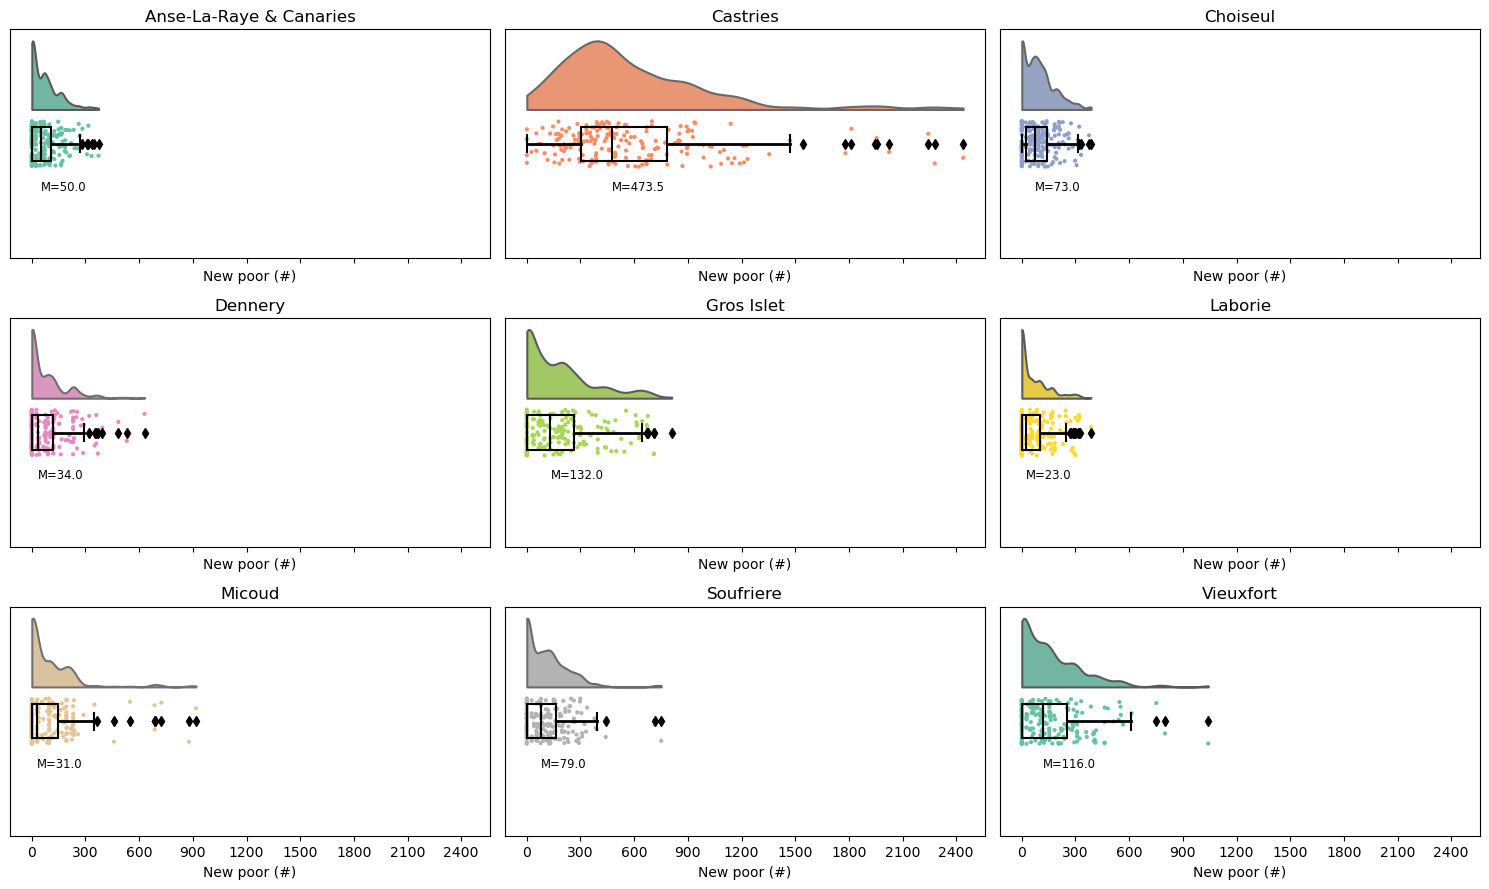

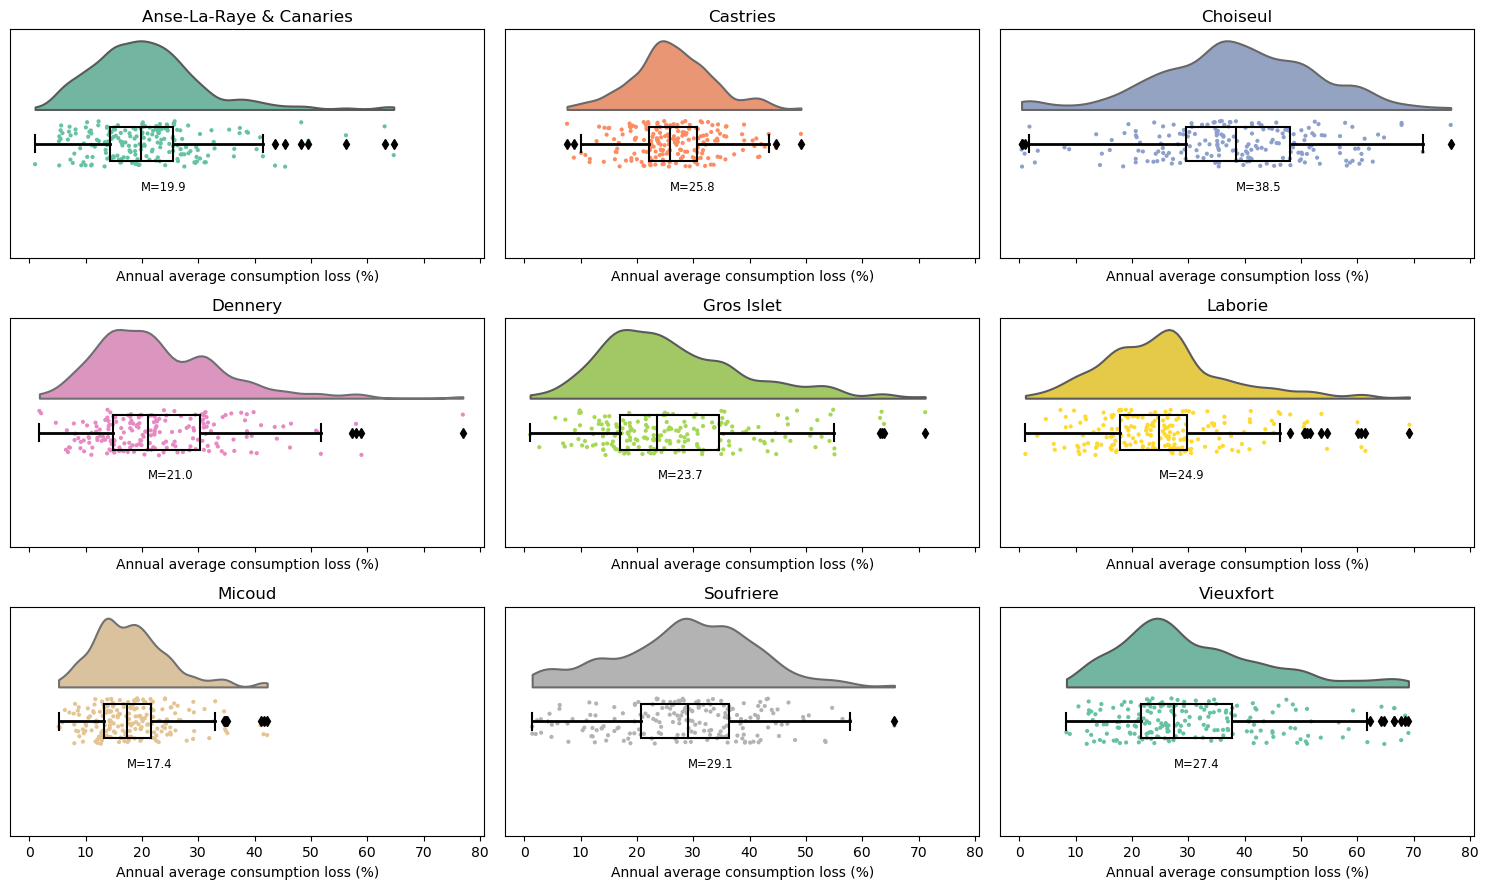

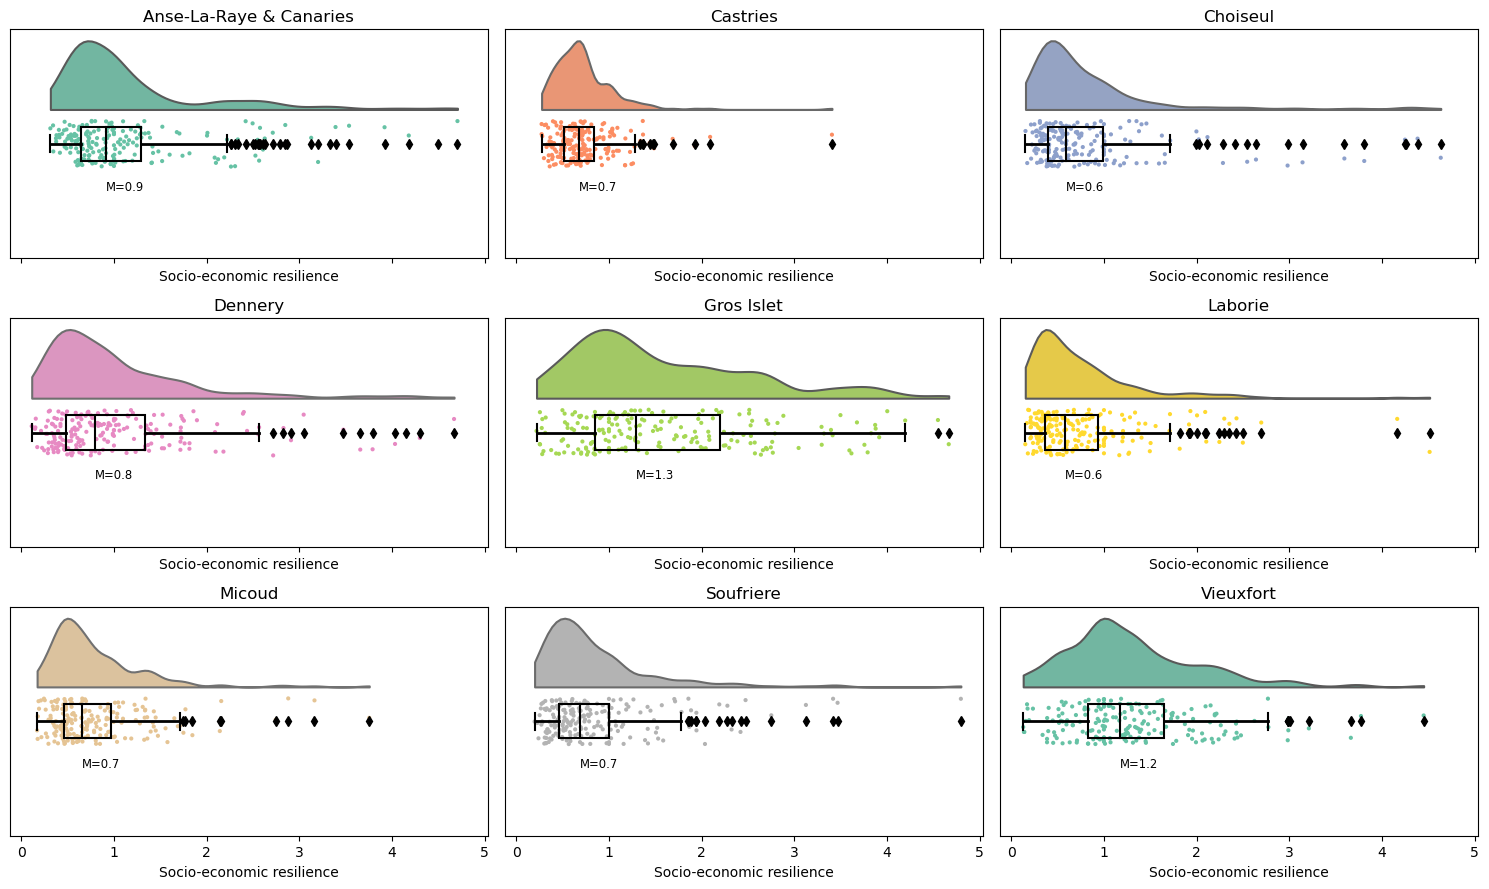

In [18]:
n_districts = len(districts)
colors = sns.color_palette('Set2', n_colors=len(districts))

x_columns = ['new_poor_increase_pct', 'new_poor', 'annual_average_consumption_loss_pct', 'r']
x_titles = ['Increase in new poor (%)', 'New poor (#)', 'Annual average consumption loss (%)', 'Socio-economic resilience']

for x_column, x_title in zip(x_columns, x_titles):
    # if x_column == 'new_poor_increase_pct' or x_column == 'annual_average_consumption_loss_pct':
    #     sharex = True
    # else:
    #     sharex = False
    sharex = True
    fig, ax = plt.subplots(ncols=3, nrows=3, figsize=(5 * n_districts / 3, 3 * n_districts / 3), sharex=sharex)

    for district in districts:
        df = outcomes[outcomes['district'] == district]
        
        # Calcualte % increase in new poor in respect to the initial number of poor
        # df = df.assign(new_poor_increase_pct = df['new_poor'].div(df['poor_initial']).multiply(100))

        # Calcualte an increase in new poor in respect to the total population
        df = df.assign(new_poor_increase_pct = df['new_poor'].div(df['total_population']).multiply(100))
        
        df = df.assign(annual_average_consumption_loss_pct = df['annual_average_consumption_loss_pct'].multiply(100))

        # Make a half violin plot
        pt.half_violinplot(x=x_column, 
                        y='policy', # hue='scenario',
                        data=df,
                        color=colors[districts.index(district)],
                        bw=.2, 
                        cut=0.,
                        scale="area", 
                        width=.6, 
                        inner=None,
                        ax=ax[districts.index(district) // 3, districts.index(district) % 3])
        
        # Add stripplot
        sns.stripplot(x=x_column,
                    y='policy', # hue='scenario',
                    data=df,
                    color=colors[districts.index(district)],
                    edgecolor='white',
                    size=3,
                    jitter=1,
                    zorder=0,
                    orient='h',
                    ax=ax[districts.index(district) // 3, districts.index(district) % 3])

        # Add boxplot
        sns.boxplot(x=x_column,
                    y='policy', # hue='scenario',
                    data=df,
                    color="black", 
                    width=.15, 
                    zorder=10,
                    showcaps=True, 
                    boxprops={'facecolor':'none', "zorder":10},
                    showfliers=True, 
                    whiskerprops={'linewidth':2, "zorder":10},
                    saturation=1, 
                    orient='h',
                    ax=ax[districts.index(district) // 3, districts.index(district) % 3])

        if district == 'AnseLaRayeCanaries':
            district_name = 'Anse-La-Raye & Canaries'
        else:
            district_name = district
        ax[districts.index(district) // 3, districts.index(district) % 3].set_title(district_name)
        ax[districts.index(district) // 3, districts.index(district) % 3].set_ylabel('')
        ax[districts.index(district) // 3, districts.index(district) % 3].set_xlabel(x_title)

        # Remove x-axis labels
        ax[districts.index(district) // 3, districts.index(district) % 3].set_yticklabels([])
        # Remove y-axis ticks
        ax[districts.index(district) // 3, districts.index(district) % 3].set_yticks([])

        # Do not display floats in the x-axis
        ax[districts.index(district) // 3, districts.index(district) % 3].xaxis.set_major_locator(MaxNLocator(integer=True))

        # Plot the median
        # ax[districts.index(district) // 3, districts.index(district) % 3].axvline(df[x_column].median(), color='black', linestyle='--', linewidth=1)
        # Add text close to the boxplot's median
        ax[districts.index(district) // 3, districts.index(district) % 3].text(df[x_column].median(), 0.2, 
                                                                               f'M={df[x_column].median():.1f}', 
                                                                               horizontalalignment='left', size='small', color='black')

    # Add a super title
    # fig.suptitle(x_title, fontsize=16)
    fig.tight_layout()
    plt.savefig(f'../figures/{x_column}.png', dpi=300, bbox_inches='tight')

In [116]:
# TODO: Make sure that uncertainty is visualized in the maps

In [ ]:
# import geopandas as gpd
# gdf = gpd.read_file('../data/raw/gadm36_LCA_shp/gadm36_LCA_1.shp')
# gdf.crs = 'EPSG:4236'
# gdf = gdf.to_crs('EPSG:3857')
# gdf.replace({'Vieux Fort' : 'Vieuxfort', 'Soufrière' : 'Soufriere'}, inplace=True)
# gdf.loc[len(gdf)] = gdf.iloc[-1,:]
# gdf.iloc[-1, gdf.columns.get_loc('NAME_1')] = 'AnseLaRayeCanaries'
# gdf.iloc[-1, gdf.columns.get_loc('GID_1')] = None
# gdf.iloc[-1, gdf.columns.get_loc('HASC_1')] = None
# gdf.iloc[-1, gdf.columns.get_loc('ENGTYPE_1')] = None
# gdf.iloc[-1, gdf.columns.get_loc('TYPE_1')] = None
# gdf.iloc[-1, gdf.columns.get_loc('geometry')] = gdf[gdf['NAME_1'].isin(['Anse-la-Raye', 'Canaries'])].unary_union
# gdf = gdf[gdf['NAME_1'].isin(districts)]
# gdf.replace({'AnseLaRayeCanaries' : 'Anse-la-Raye & Canaries'}, inplace=True)

In [114]:
# baseline = pd.merge(gdf, df['None'], left_on='NAME_1', right_index=True)
# policy_name = 'PDS'
# policy = pd.merge(gdf, df[policy_name], left_on='NAME_1', right_index=True)

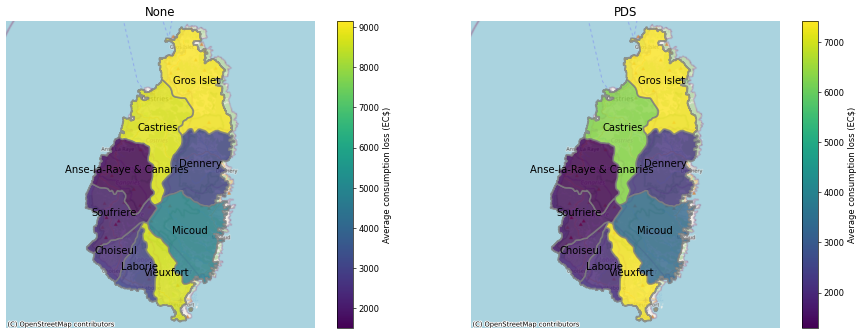

In [ ]:
# fig, ax = plt.subplots(1, 2, figsize=(20, 8))
# baseline.plot(column='None', 
#               cmap='viridis', 
#               legend=True, ax=ax[0], alpha=0.8, \
#               linewidth=2, edgecolor='0.5', \
#               legend_kwds={'label': 'Average consumption loss (EC$)'})
# policy.plot(column=policy_name, cmap='viridis', legend=True, ax=ax[1], alpha=0.8, linewidth=2, edgecolor='0.5', legend_kwds={'label': 'Average consumption loss (EC$)'})
# ax[0].set_title('None', fontsize=14)
# ax[1].set_title(policy_name, fontsize=14)
# # fig.suptitle('Mean consumption loss per household', fontsize=14)

# # Make the subplots more square-like
# xmin, ymin, xmax, ymax = gdf.total_bounds
# xmin -= 12500
# xmax += 12500
# ymin -= 1000
# ymax += 1000

# for i in range(0, 2):
#     ax[i].set_xlim(xmin, xmax)
#     ax[i].set_ylim(ymin, ymax)
#     ax[i].axis('off')
#     ctx.add_basemap(ax[i], source=ctx.providers.OpenStreetMap.Mapnik)

# # Add names of the districts to the map
# for i, txt in zip(gdf.index, gdf['NAME_1']):
#     ax[0].annotate(txt, (gdf['geometry'].centroid.x[i], gdf['geometry'].centroid.y[i]), ha='center', fontsize=12)
#     ax[1].annotate(txt, (gdf['geometry'].centroid.x[i], gdf['geometry'].centroid.y[i]), ha='center', fontsize=12)

# # # Add spacing between suptitle and titles
# fig.subplots_adjust(top=0.75)

# # Bring subplots closer to each other
# fig.subplots_adjust(wspace=0)

# # # Apply tight layout
# # fig.tight_layout()